# Intro
- This is the first jupyter notebook for the EIA interhemispheric assymmetry (IHA) seen during different solar cycles
- TEC comparison during the March equinox is carried out for different years
    - Peaks of the north and south EIA are traced and compared

# Reading New TEC Data and Producing Output Files

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')
import functions

In [ ]:
path = '/home/pxv220016/scratch/Qingyu_Cesar_EIA/2014_march_equinox/'
files = os.listdir(path)

tec_g = []
columns = ['GDLAT', 'GLON', 'TEC', 'DT']
grnd_tec = pd.DataFrame(columns=columns)

for f in tqdm(files):
    df = pd.read_csv(path+f, sep=r'\s+')
    d = [dt.datetime(y,m,d,h,mi,s) for y,m,d,h,mi,s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
    df['DT'] = d
    df = df.drop(['RECNO','KINDAT','KINST','UT1_UNIX','UT2_UNIX','YEAR','MONTH','DAY','HOUR','MIN','SEC','DTEC'], axis=1)
    if 'GDALT' in df.columns:
        df = df.drop(['GDALT'],axis=1)

    # Since data that we want is MLON = 0 and MLAT = (-40, 40) which is basically GLAT = (-52,33) and GLOM = (-74,-70)
    df = df[(df.GDLAT > -60) & (df.GDLAT < 60) & (df.GLON > -85) & (df.GLON < -45)].reset_index(drop=True)
    
    tec_g.append(df)
    grnd_tec = pd.concat([grnd_tec, df], axis = 0)

grnd_tec.reset_index(drop=True, inplace=True)
print(len(tec_g))
print(grnd_tec)


In [35]:
functions = il.reload(functions)

year = 2014

file = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_2014_march.txt'
kp = pd.read_csv(file,sep=r'\s+')

date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
m, d = zip(*date_kp)
kp['date'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
kp['kp'] = [i/10 for i in kp.Kp]
kp = kp.drop(['Year', 'DOY', 'Hour','Kp'], axis = 1)



In [40]:
functions = il.reload(functions)

grnd_tec0 = functions.kp_index_filtering(grnd_tec, kp)


In [ ]:
tqdm.pandas()

gtime = grnd_tec.DT[0]
decimal_year = gtime.year + ((gtime - dt.datetime(gtime.year, 1, 1)).days) / 365.25
apex = Apex([decimal_year])

grnd_tec1 = magnetic_coords(grnd_tec0, apex)


In [6]:
print(grnd_tec1[:10])

   GDLAT  GLON   TEC                  DT       MLAT       MLON        MLT
0  -59.0 -61.0   9.5 2014-03-20 00:02:30 -45.273872  10.114515  19.734044
1  -59.0 -60.0   9.2 2014-03-20 00:02:30 -45.355045  10.711889  19.773869
2  -58.0 -76.0  19.3 2014-03-20 00:02:30 -43.841599   0.976123  19.124818
3  -58.0 -63.0  12.7 2014-03-20 00:02:30 -44.214355   8.730050  19.641746
4  -58.0 -62.0  12.4 2014-03-20 00:02:30 -44.288891   9.328662  19.681654
5  -58.0 -60.0  12.9 2014-03-20 00:02:30 -44.456482  10.530539  19.761779
6  -58.0 -59.0  12.6 2014-03-20 00:02:30 -44.549309  11.134268  19.802027
7  -57.0 -76.0  19.5 2014-03-20 00:02:30 -42.887222   0.731193  19.108489
8  -57.0 -75.0  19.3 2014-03-20 00:02:30 -42.877193   1.336574  19.148848
9  -57.0 -67.0  14.1 2014-03-20 00:02:30 -43.048679   6.140989  19.469142


In [69]:
# you can give the MLON = (-0.5, 0.5)
grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= 5) & (grnd_tec1.MLON >= -5)].reset_index(drop=True)
grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)

grnd_tec2.to_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/2014_march_equinox.csv', index=False)

print(grnd_tec1)
print(grnd_tec2)


         GDLAT  GLON      TEC                  DT       MLAT      MLON  \
0        -53.0 -82.0  12.1548 2023-04-09 00:02:30 -39.753620 -4.424445   
1        -53.0 -81.0  11.7728 2023-04-09 00:02:30 -39.719940 -3.785207   
2        -53.0 -73.0  11.7152 2023-04-09 00:02:30 -39.733341  1.242276   
3        -53.0 -72.0  13.6761 2023-04-09 00:02:30 -39.771343  1.863705   
4        -53.0 -71.0  11.9062 2023-04-09 00:02:30 -39.817493  2.484491   
...        ...   ...      ...                 ...        ...       ...   
7707121   30.0 -76.0  54.5792 2023-03-23 23:57:30  38.856026  1.311514   
7707122   31.0 -77.0  50.6246 2023-03-23 23:57:30  39.993084  0.084889   
7707123   31.0 -76.0  49.7905 2023-03-23 23:57:30  39.820324  1.408326   
7707124   31.0 -75.0  53.5812 2023-03-23 23:57:30  39.630447  2.722746   
7707125   31.0 -74.0  54.2037 2023-03-23 23:57:30  39.423687  4.027072   

               MLT  
0        18.934534  
1        18.977150  
2        19.312315  
3        19.353744  
4     

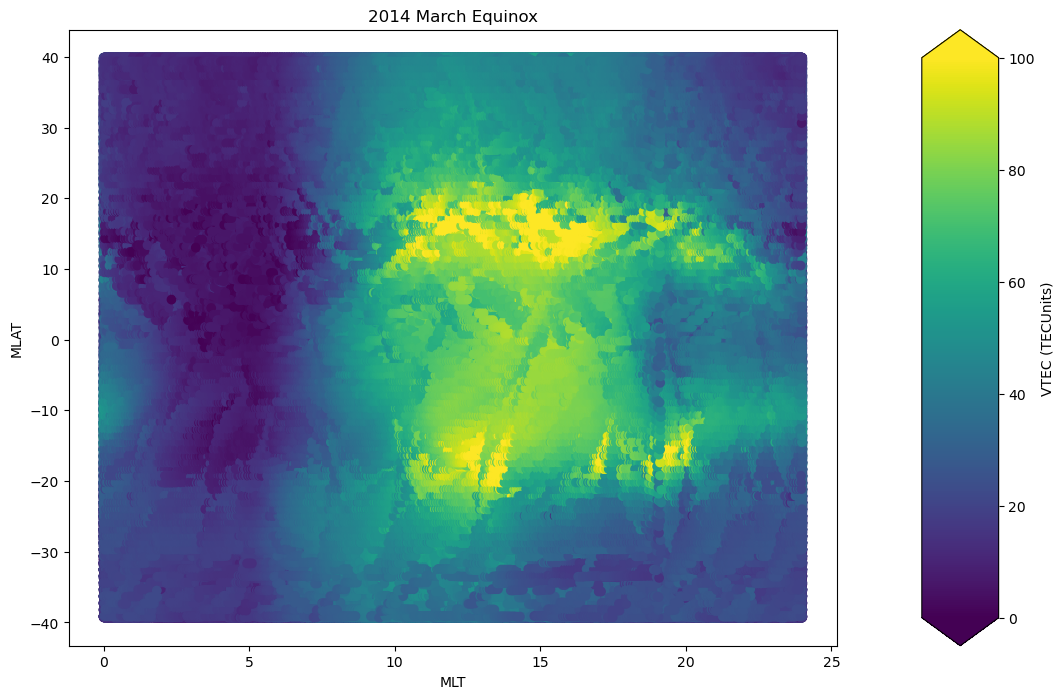

In [6]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(grnd_tec2.MLT, grnd_tec2.MLAT, c=grnd_tec2.TEC, vmax=100, vmin=0)
ax[0].set_title('2014 March Equinox')
ax[0].set_ylabel('MLAT')
ax[0].set_xlabel('MLT')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
fig.show()


# Reading Data Directly From Saved Output Files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')

In [70]:
# Reading the data from output csv
grnd_tec2 = pd.read_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/2023_march_equinox.csv')
print(grnd_tec2)

             TEC       MLAT        MLT
0        12.1548 -39.753620  18.934534
1        11.7728 -39.719940  18.977150
2        11.7152 -39.733341  19.312315
3        13.6761 -39.771343  19.353744
4        11.9062 -39.817493  19.395129
...          ...        ...        ...
7707121  54.5792  38.856026  19.093848
7707122  50.6246  39.993084  19.012073
7707123  49.7905  39.820324  19.100302
7707124  53.5812  39.630447  19.187930
7707125  54.2037  39.423687  19.274885

[7707126 rows x 3 columns]


In [74]:
# Define the bin edges for B and C
bins_mlat = pd.cut(grnd_tec2['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=2))
bins_mlt = pd.cut(grnd_tec2['MLT'], bins=pd.interval_range(start=0, end=24, freq=0.25))

# Create a new DataFrame with the bins
grnd_tec2['MLAT_b'] = bins_mlat
grnd_tec2['MLT_b'] = bins_mlt

# Group by the bins and calculate the average of A
result = grnd_tec2.groupby(['MLAT_b', 'MLT_b'])['TEC'].mean().reset_index()
print(result)

result['MLAT_b'] = result['MLAT_b'].apply(lambda x: x.mid)
result['MLT_b'] = result['MLT_b'].apply(lambda x: x.mid)
result['MLAT_b'] = result['MLAT_b'].astype(float)
result['MLT_b'] = result['MLT_b'].astype(float)

print(result)

          MLAT_b          MLT_b        TEC
0     (-40, -38]    (0.0, 0.25]  12.869948
1     (-40, -38]    (0.25, 0.5]  12.510876
2     (-40, -38]    (0.5, 0.75]  12.228287
3     (-40, -38]    (0.75, 1.0]  12.086537
4     (-40, -38]    (1.0, 1.25]  11.835408
...          ...            ...        ...
3835    (38, 40]  (22.75, 23.0]  18.289648
3836    (38, 40]  (23.0, 23.25]  17.604267
3837    (38, 40]  (23.25, 23.5]  17.230792
3838    (38, 40]  (23.5, 23.75]  17.113347
3839    (38, 40]  (23.75, 24.0]  17.229394

[3840 rows x 3 columns]
      MLAT_b   MLT_b        TEC
0      -39.0   0.125  12.869948
1      -39.0   0.375  12.510876
2      -39.0   0.625  12.228287
3      -39.0   0.875  12.086537
4      -39.0   1.125  11.835408
...      ...     ...        ...
3835    39.0  22.875  18.289648
3836    39.0  23.125  17.604267
3837    39.0  23.375  17.230792
3838    39.0  23.625  17.113347
3839    39.0  23.875  17.229394

[3840 rows x 3 columns]


In [75]:

result_t = result[result.MLT_b >= 13].reset_index(drop=True)
result_n = result_t[result_t.MLAT_b > 0].reset_index(drop=True)
result_s = result_t[result_t.MLAT_b < 0].reset_index(drop=True)

result_n = result_n.loc[result_n.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
result_s = result_s.loc[result_s.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)



/tmp/ipykernel_94962/423907873.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax[0].scatter(result_n.MLT_b, result_n.MLAT_b, c='b', vmax=100, vmin=0, cmap = 'jet')
/tmp/ipykernel_94962/423907873.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax[0].scatter(result_s.MLT_b, result_s.MLAT_b, c='b', vmax=100, vmin=0, cmap = 'jet')


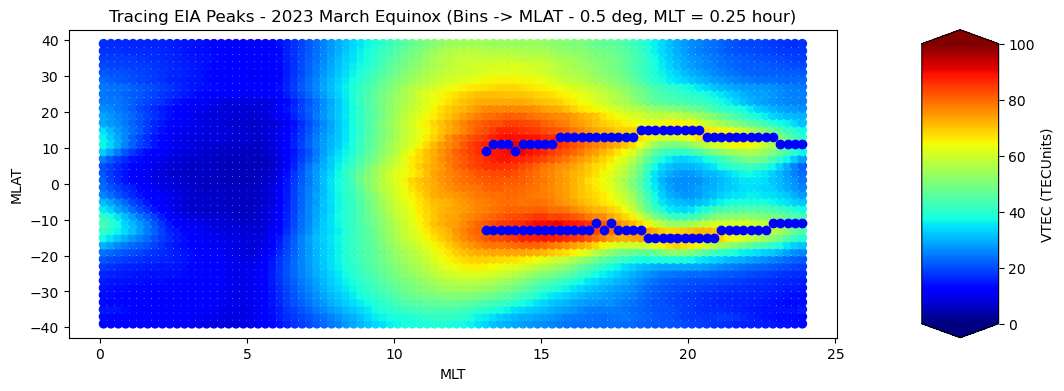

In [76]:

fig = plt.figure(figsize=(12,4))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(result.MLT_b, result.MLAT_b, c=result.TEC, vmax=100, vmin=0, cmap = 'jet')
ax[0].scatter(result_n.MLT_b, result_n.MLAT_b, c='b', vmax=100, vmin=0, cmap = 'jet')
ax[0].scatter(result_s.MLT_b, result_s.MLAT_b, c='b', vmax=100, vmin=0, cmap = 'jet')
ax[0].set_title('Tracing EIA Peaks - 2023 March Equinox (Bins -> MLAT - 0.5 deg, MLT = 0.25 hour)')
ax[0].set_ylabel('MLAT')
ax[0].set_xlabel('MLT')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
fig.show()